In [2]:
import gym
import gym_defender
import os
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
import random
from matplotlib.pyplot import plot

In [2]:
#env = gym.make('defender-5-0.8-v0')

In [17]:
class Agent():
    def __init__(self, state_size, action_size):
        self.weight_backup      = "defender-5-08.h5"
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=2000)
        self.learning_rate      = 0.001
        self.gamma              = 0.95
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.995
        self.brain              = self._build_model()

    def _build_model(self):
            # Neural Net for Deep-Q learning Model
            model = Sequential()
            model.add(Dense(300, input_dim=self.state_size, activation='relu'))
            model.add(Dense(300, activation='relu'))
            model.add(Dense(self.action_size, activation='linear'))
            model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

       #     if os.path.isfile(self.weight_backup):
        #        model.load_weights(self.weight_backup)
         #       self.exploration_rate = self.exploration_min
            return model

    def save_model(self):
            self.brain.save(self.weight_backup)

    def act(self, state):
            if np.random.rand() <= self.exploration_rate:
                return random.randrange(self.action_size)
            act_values = self.brain.predict(state)
            return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
            self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size):
            if len(self.memory) < sample_batch_size:
                return
            sample_batch = random.sample(self.memory, sample_batch_size)
            for state, action, reward, next_state, done in sample_batch:
                target = reward
                if not done:
                    target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
                target_f = self.brain.predict(state)
                target_f[0][action] = target
                self.brain.fit(state, target_f, epochs=1, verbose=0)
            if self.exploration_rate > self.exploration_min:
                self.exploration_rate *= self.exploration_decay

Episode 0#; 	 Nb of steps: 3; 	 Reward: -1.
Episode 1000#; 	 Nb of steps: 2; 	 Reward: 1.
Episode 2000#; 	 Nb of steps: 4; 	 Reward: 1.
Episode 3000#; 	 Nb of steps: 5; 	 Reward: 1.
Episode 4000#; 	 Nb of steps: 4; 	 Reward: 1.
Episode 5000#; 	 Nb of steps: 2; 	 Reward: 1.
Episode 6000#; 	 Nb of steps: 4; 	 Reward: 1.
Episode 7000#; 	 Nb of steps: 2; 	 Reward: 1.
Episode 8000#; 	 Nb of steps: 4; 	 Reward: 1.
Episode 9000#; 	 Nb of steps: 2; 	 Reward: 1.


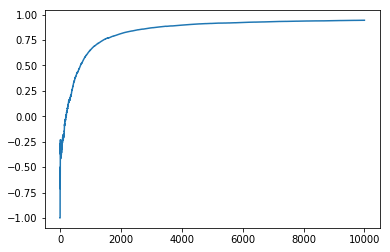

In [19]:
class Defense:
    def __init__(self):
        self.sample_batch_size = 32
        self.episodes          = 10000
        self.env               = gym.make('defender-5-0.95-v1')

        self.state_size        = 2 * (self.env.K + 1)
        self.action_size       = 2
        self.agent             = Agent(self.state_size, self.action_size)
        self.reward            = []

    def run(self):
            try:
                for index_episode in range(self.episodes):
                    state = self.env.reset()
                    state = np.reshape(np.array(state), [1, self.state_size])
                    done = False
                    index = 0
                    while not done:
          #               self.env.render()
                         action = self.agent.act(state)
                         next_state, reward, done, _ = self.env.step(action)
                         next_state = np.reshape(np.array(next_state), [1, self.state_size])
                         self.agent.remember(state, action, reward, next_state, done)
                         state = next_state
                         index += 1
                    if index_episode %1000 == 0:
                        print("Episode {}#; \t Nb of steps: {}; \t Reward: {}.".format(index_episode, index + 1, reward))
                    if index_episode > 0:
                        self.reward += [((self.reward[-1] * len(self.reward)) + reward) / (len(self.reward) + 1)]
                    else:
                        self.reward += [reward]
                    self.agent.replay(self.sample_batch_size)
            finally:
                self.agent.save_model()

if __name__ == "__main__":
    defense = Defense()
    defense.run()
    plot(range(1,defense.episodes+1),defense.reward)